In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's define an artificial time series which is a perfectly periodic train of spikes, each of short duration:

Timestep 0.10


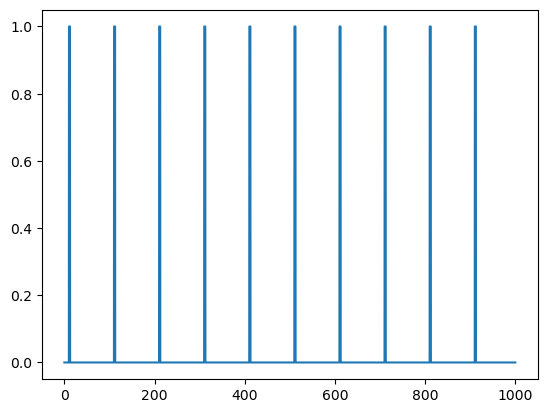

In [33]:
times = np.linspace(0,1000,10000)
dt = np.median(np.diff(times))
print('Timestep %.2f' % dt)

offset = 10
period = 100
periodic = 1.0*(np.abs((times-offset) % period) < 2.5)

plt.plot(times,periodic)

Now let's create a timeseries where we split each peak into 2 (you could convolve with two delta functions, but instead we are going to sum two rolled arrays)... and then do that again, splitting each of those 2 into 2. 

First splitting 15.00 
Second splitting  8.00


(0.0, 140.0)

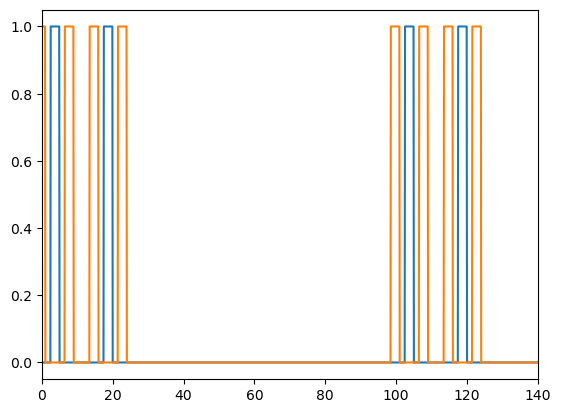

In [174]:
split1 = 75
first = np.roll(periodic,split1) + np.roll(periodic,-split1)
print('First splitting %.2f ' % (split1*dt*2))

split2 = 40
second = np.roll(first,split2) + np.roll(first,-split2)
print('Second splitting % .2f' % (split2*dt*2))

plt.plot(times,first)
plt.plot(times,second)
plt.xlim(0,140)

Let's visualize what `diff` does to this, and how we can detect the spikes themselves:

Starts: [ 10.00 110.01 210.02 310.03 410.04 510.05 610.06 710.07 810.08 910.09], Durations [2.40 2.40 2.40 2.40 2.40 2.40 2.40 2.40 2.40 2.40]


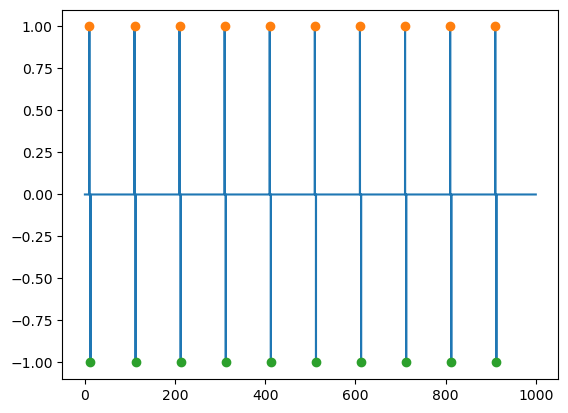

In [118]:
x = times
y = periodic
plt.plot(times[:-1],np.diff(y,1))

ups = np.where(np.diff(y,1) > 0)[0]+1 # find where it went up
downs = np.where(np.diff(y,1) < 0)[0] # find where it went down
lens = times[downs] - times[ups] # assuming these are always paired and you're not cut off at the end, each has a finite duration
centres = times[ups] + lens/2 # the centre of each event
print(f'Starts: {np.array2string(x[ups], precision=2, floatmode="fixed")}, Durations {np.array2string(lens, precision=2, floatmode="fixed")}') # print these
# print(np.array2string(x[ups], precision=2, floatmode='fixed'))
plt.plot(x[ups],y[ups],'o') # plot these
plt.plot(x[downs],-y[downs],'o')
# plt.xlim(0,50)

Let's wrap that up as a function, `get_events`:

In [172]:
def get_events(times,y):
    '''
    Given a time series, find the centres and durations of all events

    Parameters
    ----------
    y : array of values (assumed to be evenly spaced in time)

    Returns
    -------
    centres : array of times of the centre of each event
    durations : array of durations of each event

    '''
    ups = np.where(np.diff(y,1) > 0)[0]+1 # find where it went up
    downs = np.where(np.diff(y,1) < 0)[0] # find where it went down

    # check that the events are always paired - the first up is before the first down, and the last up is before the last down
    if ups[0] > downs[0]:
        downs = np.delete(downs,0)
    elif ups[-1] > downs[-1]:
        ups = np.delete(ups,-1)

    full_length = np.min([len(ups),len(downs)])
    ups, downs = ups[:full_length], downs[:full_length] # trim to the same length

    durations = times[downs] - times[ups] # assuming these are always paired and you're not cut off at the end, each has a finite duration
    centres = times[ups] + durations/2 # the centre of each event

    return centres, durations

centres_0, durations_0 = get_events(times,periodic)
centres_1, durations_1 = get_events(times,first)
centres_2, durations_2 = get_events(times,second)

How well does this detect the individual pulses in this train?

(0.0, 200.0)

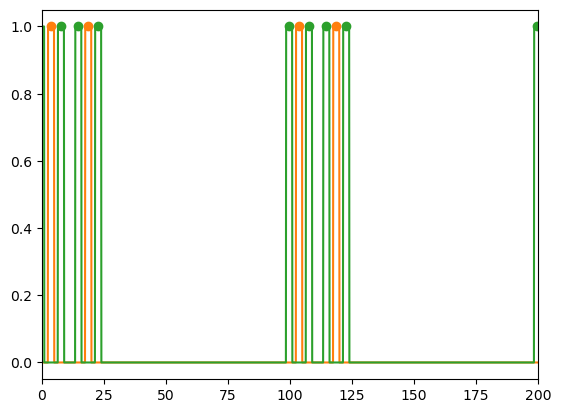

In [120]:
plt.plot(times,first,color='C1')
plt.plot(times,second,color='C2')

plt.plot(centres_1,np.ones_like(centres_1),'o',color='C1')
plt.plot(centres_2,np.ones_like(centres_2),'o',color='C2')
plt.xlim(0,200)

Now I want to take those centres, and define a function that will calculate their separations and the midpoints:

In [80]:
def group_events(centres):
    '''
    Given a time series and a list of event centres, group the events into clusters

    Parameters
    ----------
    centres : array of event centres

    Returns
    -------
    groups : list of arrays of event centres, grouped into clusters

    '''

    durations = np.diff(centres)
    centres = centres[:-1] + durations/2
    
    return durations, centres
    

Visualize this - it's a bit of a mess but it clearly gets the event clusters. In order to recover the middles of these events, we just have to find the `centre` that corresponds to the minimum `duration`:

(50.0, 250.0)

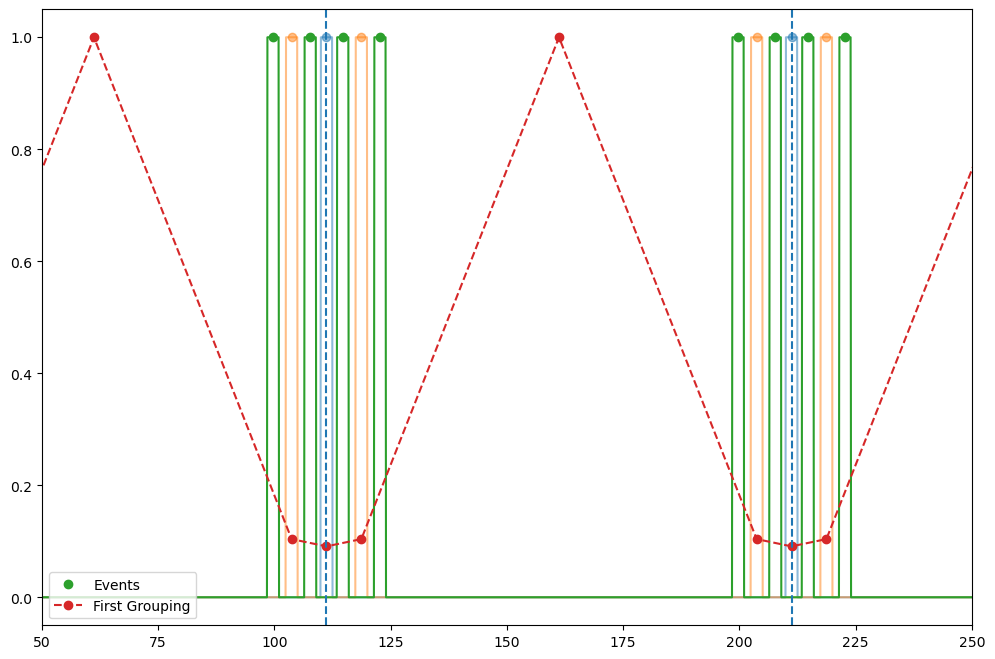

In [161]:
d1, m1 = group_events(centres_1)
d2, m2 = group_events(centres_2)
# do this hierarchically

fig = plt.figure(figsize=(12.0,8.0))

plt.plot(times,periodic,color='C0',alpha=0.5)
plt.plot(times,first,color='C1',alpha=0.5)
plt.plot(times,second,color='C2')

plt.plot(centres_0,np.ones_like(centres_0),'o',color='C0',alpha=0.5)
plt.plot(centres_1,np.ones_like(centres_1),'o',color='C1',alpha=0.5)
plt.plot(centres_2,np.ones_like(centres_2),'o',color='C2',label='Events')
plt.plot(m2,(d2/d2.max()),'--o',color='C3',label='First Grouping')


# find the minima
args = np.where(np.abs(d2 - np.min(d2))<0.01)[0]

for cen in m2[args]:
    plt.axvline(cen,color='C0',markersize=10,linestyle='--')

plt.legend(loc=3)

plt.xlim(50,250)


In [182]:
true_durations, timings = group_events(m2[args])
print('Estimated true period % .2f' % np.median(true_durations))

Estimated true period  100.01


So we have been able to recover the spacing of the original events with only 2 hierarchical uses. Meanwhile, the splittings are accurately inferred too:

In [175]:
print('First splitting %.2f' % np.median(d1))
print('Second splitting %.2f' % np.median(d2))

First splitting 15.00
Second splitting 8.00
